## Home Task 4 ⏰

Download Yoga-82 dataset (will be attached).

1) Perform Exploratory Data Analysis (EDA).
* visualize the dataset (sample images per class, class distribution image sizes, etc.)
* identify potential class imbalances
* provide key statistics about the dataset
* any other interesting observations are welcome

2) Implement data augmentations (either with Albumentations or Torchvision transforms).

You can split the Training set into "training" and "validation" as you like.

3) Using PyTorch Lightning, implement the training pipeline.

Start from the baseline model, specify the hyperparameters (batch size, learning rate, etc).

You can implement techniques such as weight decay, learning rate scheduling, etc.

Conduct an ablation study to analyze the impact of different techniques. For example:

* compare training without vs with data augmentation,
* measure the effect of different optimizers or scheduling strategies,
* compare same family of models, but of different depth,
* compare different activation functions if possible.

This is a creative task, try various options, but report few meaningful ones (no need to report an avalanche of the experiments that didn't bring any insights and didn't indicate any performance change).

4) Compute key metrics: accuracy, precision, recall, F1-score. Visualize the learning curves (training vs validation loss and accuracy). Generate a confusion matrix to analyze misclassifications. Report per-class performance (which classes perform poorly and why?).

5) Submit a structured report with the code snippets only where necessary and/or informative. Summarize key findings after describing each stage aforementioned. Provide a GitHub link or Google Colab notebook.

## Install Requirements

In [4]:
!pip install torch -q
!pip install torchvision -q
!pip install torchmetrics -q
!pip install matplotlib -q
!pip install numpy -q
!pip install tqdm -q
!pip install opencv-python -q
!pip install albumentations -q
!pip install pytorch_lightning -q
!pip install seaborn -q
!pip install scikit-learn -q

In [ ]:
import os
import pickle
import requests
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
# from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

# uncomment the following lines if you are using colab
# from google.colab import drive
# import gdown

## Download Yoga-82 Dataset

First get zip file and upload it to your drive.

In [ ]:
# uncomment the following lines if you are using Google Colab
# drive.mount('/content/drive')

# zip_url = 'https://drive.google.com/uc?id=1Qy71D7FIAacBnk4IR9wc8-eBu7IYKMb4'

# # change to your desired path, where dataset will be stored
# zip_path = '/content/drive/MyDrive/cv/hw2/dataset/Yoga-82.zip'
# folder_path = '/content/drive/MyDrive/cv/hw2/dataset/Yoga-82'

# gdown.download(zip_url, zip_path, quiet=False)

# if os.path.exists(zip_path):
#     !unzip -u "$zip_path" -d "$folder_path"
# else:
#     print(f"zip file does not exist at the specified path: {zip_path}")

In [7]:
# if running locally 
# download the data from https://drive.google.com/file/d/1Qy71D7FIAacBnk4IR9wc8-eBu7IYKMb4/view?usp=sharing
# and unzip it to the folder_path
folder_path = './dataset/Yoga-82'

Parses the URLs from `yoga_dataset_links` and downloads the images to `images` folder.

In [8]:
image_folder = os.path.join(folder_path, "Yoga-82/images")
yoga_links_folder = os.path.join(folder_path, "Yoga-82/yoga_dataset_links")
os.makedirs(image_folder, exist_ok=True)

In [ ]:
def download_image(line):
    """download a single image from a url"""
    try:
        if "\t" not in line:
            return f"Invalid line format: {line}"

        img_path, url = line.split("\t")
        class_name, img_name = img_path.split("/") # get class label
        class_folder = os.path.join(image_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)

        img_save_path = os.path.join(class_folder, img_name)
        if os.path.exists(img_save_path):
            return f"Skipped: {img_save_path}"

        # download image
        with requests.get(url, stream=True, timeout=10) as response:
            if response.status_code == 200:
                with open(img_save_path, "wb") as img_file:
                    for chunk in response.iter_content(1024):
                        img_file.write(chunk)
                return f"Downloaded: {img_save_path}"
            else:
                return f"Failed: {url} with status code {response.status_code}"
    except (requests.RequestException, OSError) as e:
        return f"Error: {e}"

# read all file lines
all_lines = []
for file_name in os.listdir(yoga_links_folder):
    with open(os.path.join(yoga_links_folder, file_name), "r") as f:
        all_lines.extend(f.read().splitlines())

def download_all_images(all_lines):
    results = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        for result in tqdm(executor.map(download_image, all_lines), total=len(all_lines), desc="Downloading Images"):
            results.append(result)
            print(result)

download_all_images(all_lines)

Get train and test images and labels.

In [10]:
def get_image_filepaths_and_labels(txt_file):
    image_filepaths = []
    labels = []
    with open(txt_file, 'r') as f:
        for line in f:
            img_path, label_6, label_20, label_82 = line.strip().split(',')
            img_filepath = os.path.join(image_folder, img_path)
            image_filepaths.append(img_filepath)
            labels.append((int(label_6), int(label_20), int(label_82)))  # store the labels as a tuple
    return image_filepaths, labels

yoga_train_path = os.path.join(folder_path, "Yoga-82/yoga_train.txt")
yoga_test_path = os.path.join(folder_path, "Yoga-82/yoga_test.txt")

train_images_filepaths, train_labels = get_image_filepaths_and_labels(yoga_train_path)
test_images_filepaths, test_labels = get_image_filepaths_and_labels(yoga_test_path)

Check if images are valid.

In [ ]:
chkpt_folder = os.path.join(folder_path, "chkpt")
os.makedirs(chkpt_folder, exist_ok=True)

valid_train_images_path = os.path.join(chkpt_folder, "valid_train_images.pkl")
valid_test_images_path = os.path.join(chkpt_folder, "valid_test_images.pkl")

def is_valid_image(filepath):
    image = cv2.imread(filepath)
    if image is None:
        print(f"Invalid image: {filepath}")
        return False
    return True

def save_to_pickle(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)

def load_from_pickle(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def validate_images(image_paths, save_path):
    # if os.path.exists(save_path):
    #     print(f"loading previously validated images from {save_path}")
    #     return load_from_pickle(save_path)

    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(tqdm(executor.map(is_valid_image, image_paths), total=len(image_paths), desc="validating images"))

    valid_images = [path for path, result in zip(image_paths, results) if result]
    save_to_pickle(valid_images, save_path)

    print(f"saved validated images to {save_path}")
    return valid_images

# validate images or load from chkpt
valid_train_images = validate_images(train_images_filepaths, valid_train_images_path)
valid_test_images = validate_images(test_images_filepaths, valid_test_images_path)

train_images_with_labels = [(path, label) for path, label in zip(train_images_filepaths, train_labels) if path in valid_train_images]
test_images_with_labels = [(path, label) for path, label in zip(test_images_filepaths, test_labels) if path in valid_test_images]

train_images, train_labels = zip(*train_images_with_labels) if train_images_with_labels else ([], [])
test_images, test_labels = zip(*test_images_with_labels) if test_images_with_labels else ([], [])

There were lots of corrupted images, as some links were invalid..

## Exploratory Data Analysis

Plot sample images per class.

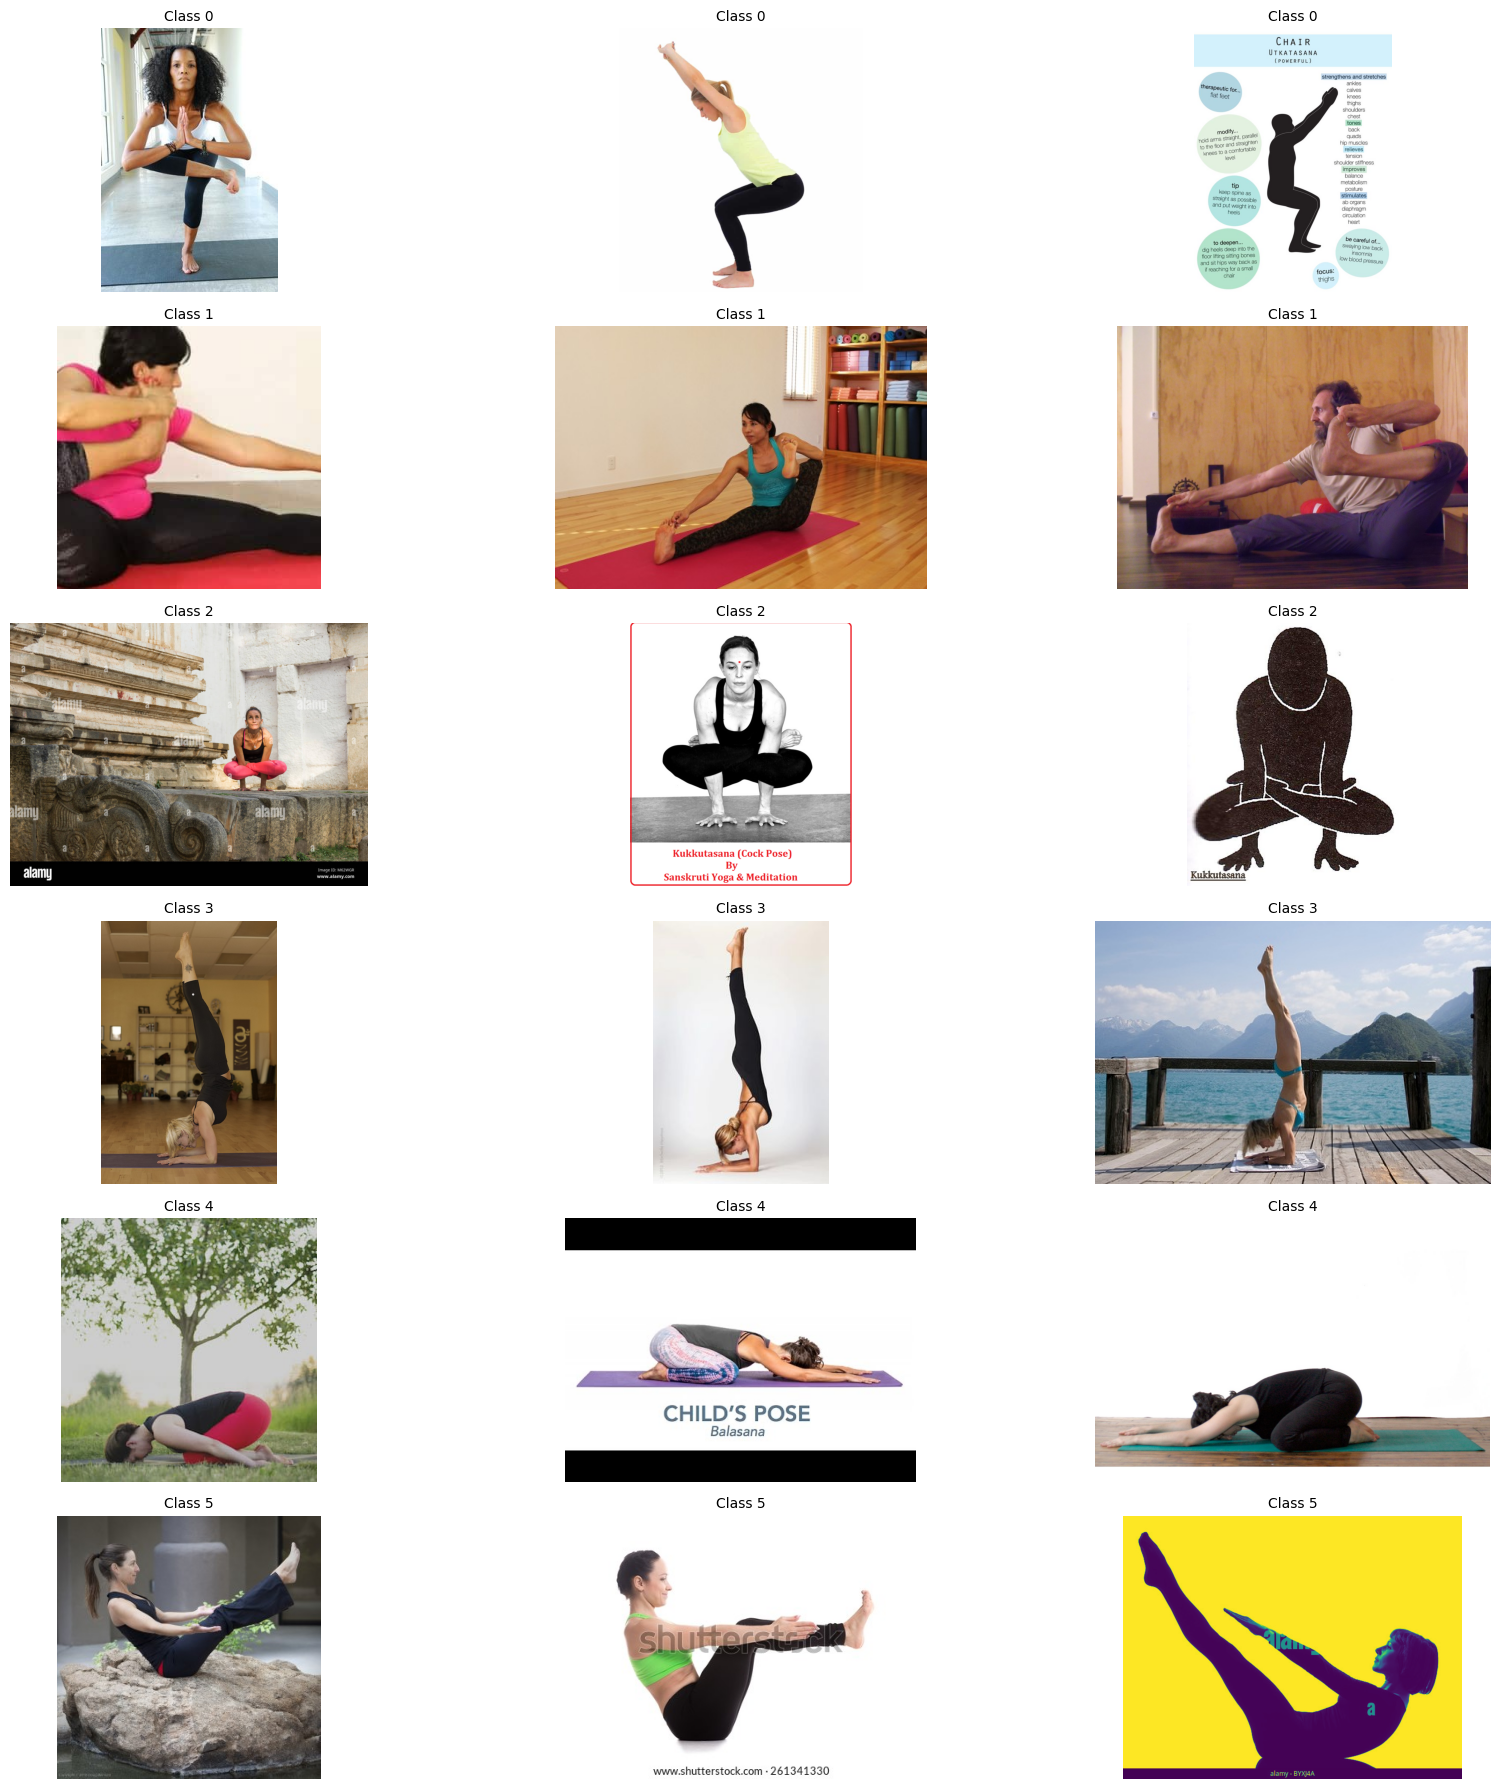

In [12]:
def plot_class_samples(image_paths, labels, num_classes=6, images_per_class=3):
    class_samples = {i: [] for i in range(num_classes)}

    combined = list(zip(image_paths, labels))

    for path, label in combined:
        class_label = label[0]
        if class_label in class_samples and len(class_samples[class_label]) < images_per_class:
            class_samples[class_label].append(path)
        if all(len(v) == images_per_class for v in class_samples.values()):
            break

    sorted_classes = sorted(class_samples.items())

    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(18, 3 * num_classes))

    for row, (label, paths) in enumerate(sorted_classes):
        for col, path in enumerate(paths):
            ax = axes[row, col] if num_classes > 1 else axes[col]
            img = Image.open(path)
            ax.imshow(img)
            ax.set_title(f"Class {label}", fontsize=10)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_class_samples(train_images, train_labels)

The Yoga-82 dataset contains images of yoga poses organized into 82 classes, which can be grouped into 20 intermediate classes or 6 broad classes. Here I display 6 classes and will further work with 6 classes.

Plot class distribution.

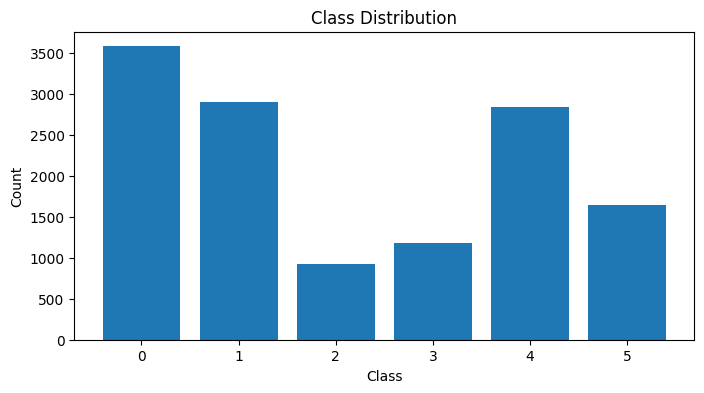

In [13]:
from collections import Counter

def plot_class_distribution(labels):
    class_counts = Counter(label[0] for label in labels)

    plt.figure(figsize=(8, 4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.xticks(sorted(class_counts.keys()))
    plt.show()

plot_class_distribution(train_labels)

The class distribution appears to be quite imbalanced, with classes 2, 3, 5 having fewer samples. This imbalance could potentially bias the model toward the majority classes, that is 0, 1 and 4.

Plot image size distribution.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known

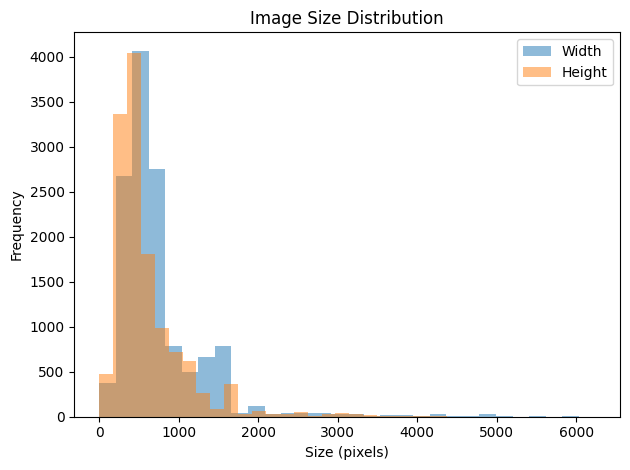

In [14]:
def analyze_image_sizes(image_paths):
    image_sizes = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            image_sizes.append((w, h))
    return image_sizes

def plot_image_size_distribution(image_sizes):
    widths, heights = zip(*image_sizes)

    plt.hist(widths, bins=30, alpha=0.5, label='Width')
    plt.hist(heights, bins=30, alpha=0.5, label='Height')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

image_sizes = analyze_image_sizes(train_images)
plot_image_size_distribution(image_sizes)

As we can see the most commin size distibution is near 512 by 512.

From this point forward, there will be libpng warnings; they don't influence the training process.
Sorry for that clutter...

## Data Preparation and Augmentation

In [15]:
torch.cuda.device_count()
num_workers = torch.cuda.device_count() - 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = {
    "model_densenet121": "densenet121",
    "model_densenet161": "densenet161",
    "model_densenet169": "densenet169",
    "model_densenet201": "densenet201",

    "num_classes_6": 6,
    "num_classes_20": 20,
    "num_classes_82": 82,

    "device": device,
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": num_workers,
    "epochs": 5,
}

Split dataset to train/val/test.

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, stratify=train_labels)

print(f"Train size: {len(train_images)}, Train labels size: {len(train_labels)}")
print(f"Validation size: {len(val_images)}, Validation labels size: {len(val_labels)}")
print(f"Test size: {len(test_images)}, Test labels size: {len(test_labels)}")

Train size: 11799, Train labels size: 11799
Validation size: 1311, Validation labels size: 1311
Test size: 4537, Test labels size: 4537


Create custom dataset class.

In [17]:
class YogaDataset(Dataset):
  def __init__(self, images_filepaths, labels, num_classes, transform=None):
    self.images_filepaths = images_filepaths
    self.labels = labels
    self.num_classes = num_classes
    self.transform = transform

  def __len__(self):
    return len(self.images_filepaths)

  def __getitem__(self, idx):
    image = cv2.imread(self.images_filepaths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.num_classes == 6:
      label = self.labels[idx][0]
    if self.num_classes == 20:
      label = self.labels[idx][1]
    if self.num_classes == 82:
      label = self.labels[idx][2]

    if self.transform:
      image = self.transform(image=image)["image"]

    return image, torch.tensor(label, dtype=torch.long)

Data augmentations.

In [ ]:
test_transform_no_augmentation = A.Compose(
    [
        # no augmentations, just basic resizing and normalization
        # this is for testing the results with no data augmentation
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=10, p=0.4),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

/root/hw2/venv/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [19]:
train_dataset = YogaDataset(images_filepaths=train_images, labels=train_labels, num_classes=params["num_classes_6"], transform=train_transform)
train_dataset_no_augmentation = YogaDataset(images_filepaths=train_images, labels=train_labels, num_classes=params["num_classes_6"], transform=test_transform_no_augmentation)
val_dataset = YogaDataset(images_filepaths=val_images, labels=val_labels, num_classes=params["num_classes_6"], transform=train_transform)
test_dataset = YogaDataset(images_filepaths=test_images, labels=test_labels, num_classes=params["num_classes_6"], transform=train_transform)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,)
train_loader_no_augmentation = DataLoader(train_dataset_no_augmentation, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,)

## Training Pipeline

In [21]:
class MetricsCallback(pl.Callback):
  def __init__(self):
    super().__init__()
    self.train_metrics = {'loss': [], 'acc': []}
    self.val_metrics = {'loss': [], 'acc': []}
    self.validation_step_called = False

  def on_train_epoch_end(self, trainer, pl_module):
    self.train_metrics['loss'].append(trainer.callback_metrics.get('train_loss', 0).item())
    self.train_metrics['acc'].append(trainer.callback_metrics.get('train_acc', 0).item())

  def on_validation_epoch_end(self, trainer, pl_module):
    self.val_metrics['loss'].append(trainer.callback_metrics.get('val_loss', 0).item())
    self.val_metrics['acc'].append(trainer.callback_metrics.get('val_acc', 0).item())
    self.validation_step_called = True

  def plot_metrics(self):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    train_loss = self.train_metrics['loss']
    val_loss = self.val_metrics['loss']
    train_acc = self.train_metrics['acc']
    val_acc = self.val_metrics['acc']

    if self.validation_step_called and len(val_loss) > len(train_loss):
      # remove val results from epoch 0
      val_loss = val_loss[1:]
      val_acc = val_acc[1:]

    ax1.plot(self.train_metrics['loss'], label='Train Loss')
    ax1.plot(self.val_metrics['loss'], label='Val Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(self.train_metrics['acc'], label='Train Accuracy')
    ax2.plot(self.val_metrics['acc'], label='Val Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

The following experiments are conducted as follows:
1. Train with/without data augmentations on a baseline model with the same training pipeline.
2. Train baseline model w data augmentaitons w SGD Optimizer, Adam Optimizer, AdamW Optimizer, RMSprop Optimizer.
3. Train baseline model w data augmentaiton w StepLR Scheduler, Cosine Annealing Scheduler, Cyclical Learning Rate.
4. Train different denseNet variants: densenet121, densenet161, densenet169, and densenet201.
5. Train with different activation functions: nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.Sigmoid(), nn.Tanh().

In [ ]:
def run_experiment(model_name, num_classes, optimizer='adam', weight_decay=0.0,
                   lr_scheduler_choice=False, activation_func=nn.ReLU,
                   use_augmentation=True, experiment_name=None, epochs=params["epochs"]):
    if experiment_name is None:
        experiment_name = f"{model_name}_{optimizer}"
        if lr_scheduler_choice:
            experiment_name += "_scheduler"
        if weight_decay > 0:
            experiment_name += f"_wd{weight_decay}"
        if activation_func != nn.ReLU:
            experiment_name += f"_{activation_func.__name__}"
        if not use_augmentation:
            experiment_name += "_noaug"

    checkpoint_callback = ModelCheckpoint(
        monitor="val_acc",
        dirpath=f"checkpoints/{experiment_name}",
        filename=f"{experiment_name}-epoch{{epoch:02d}}-val_acc{{val_acc:.4f}}",
        save_top_k=3,
        mode="max",
        )   

    early_stop_callback = EarlyStopping(
        monitor="val_acc",
        min_delta=0.001,
        patience=3,
        verbose=True,
        mode="max"
        )

    # logger = TensorBoardLogger("lightning_logs", name=experiment_name)
    metrics_callback = MetricsCallback()
    lr_monitor = LearningRateMonitor(logging_interval='step')

    model = YogaModel(
        model=model_name,
        num_classes=num_classes,
        lr=params["lr"],
        optimizer=optimizer,
        weight_decay=weight_decay,
        lr_scheduler_choice=lr_scheduler_choice,
        activation_func=activation_func
    )

    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        # logger=logger,
        logger=None,
        callbacks=[checkpoint_callback, early_stop_callback, metrics_callback, lr_monitor]
    )

    train_loader_to_use = train_loader if use_augmentation else train_loader_no_augmentation
    trainer.fit(model, train_dataloaders=train_loader_to_use, val_dataloaders=val_loader)
    metrics_callback.plot_metrics()
    test_results = trainer.test(model, dataloaders=test_loader)
    conf_matrix = model.get_confusion_matrix(test_loader)
    plot_confusion_matrix(conf_matrix)

    return model, test_results, metrics_callback

### 1. Train with/without data augmentations on a baseline model with the same training pipeline.

#### Baseline pre-trained `densenet121` model without data augmentations.

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential co

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.722
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.082 >= min_delta = 0.001. New best score: 0.804
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.009 >= min_delta = 0.001. New best score: 0.813
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.008 >= min_delta = 0.001. New best score: 0.821
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
lib

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
`Trainer.fit` stopped: `max_epochs=5` reached.


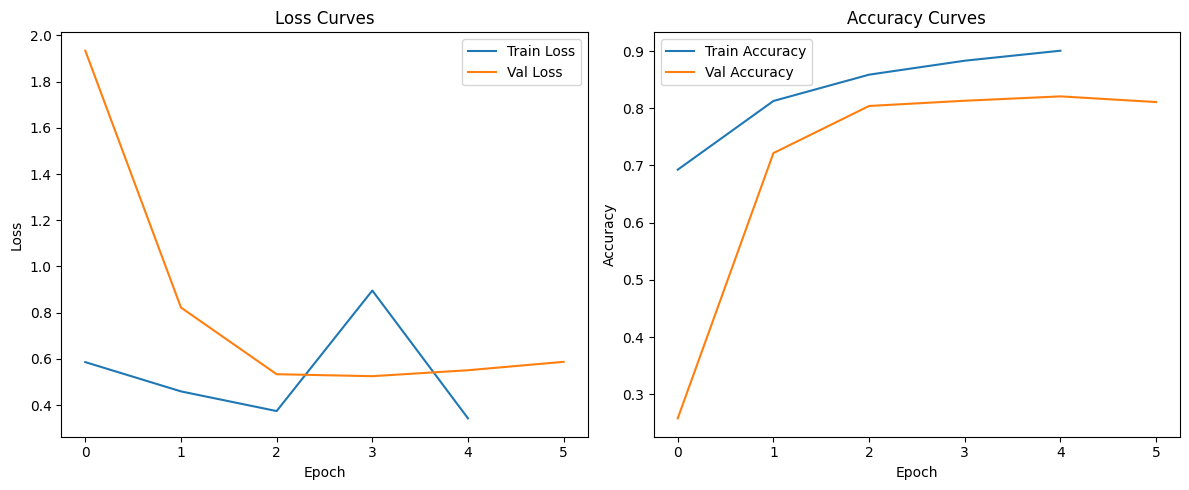

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7961207628250122
        test_loss           0.6090636253356934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


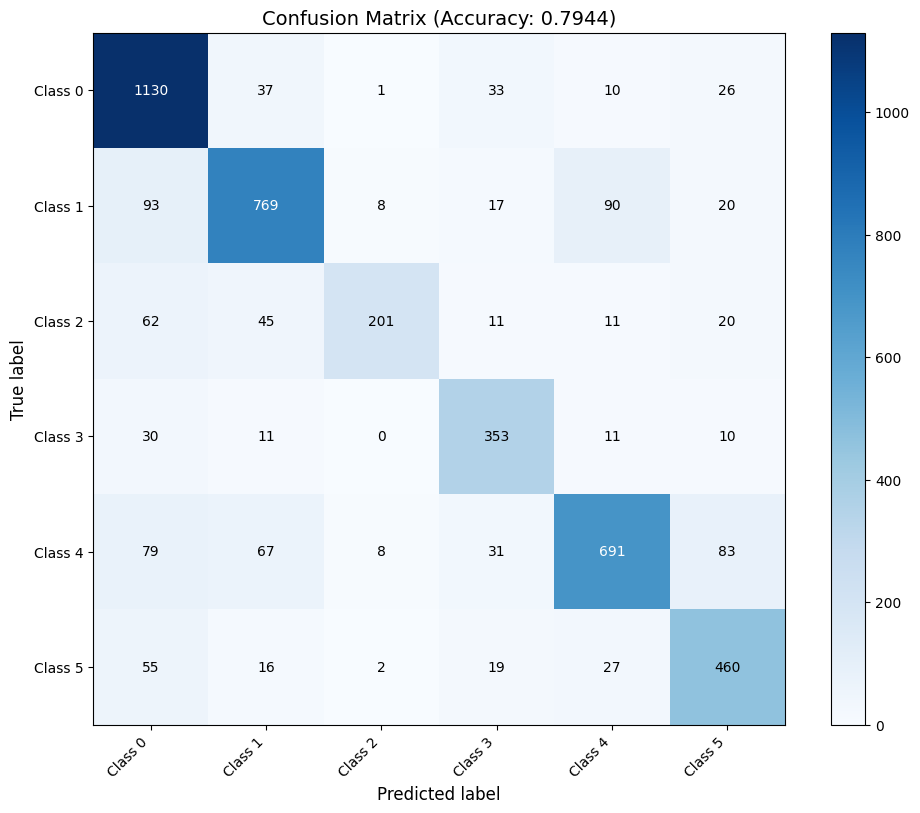

In [25]:
model_noaug, results_noaug, metrics_df_noaug = run_experiment(
    params["model_densenet121"],
    params["num_classes_6"],
    use_augmentation=False,
)

Worth noting:

class 0: high recall with only a few misclassifications into other classes; this is expected, as class 0 has the most samples in the training dataset.

class 2: had the fewest samples and is often misclassified as class 0 or class 1.

class 3: high recall despite having a small number of samples.

#### Baseline pre-trained `densenet121` model with data augmentations.

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /root/hw2/checkpoints/densenet121_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Ty

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.725
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.069 >= min_delta = 0.001. New best score: 0.793
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile'

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.031 >= min_delta = 0.001. New best score: 0.824
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.011 >= min_delta = 0.001. New best score: 0.834
`Trainer.fit` stopped: `max_epochs=5` reached.


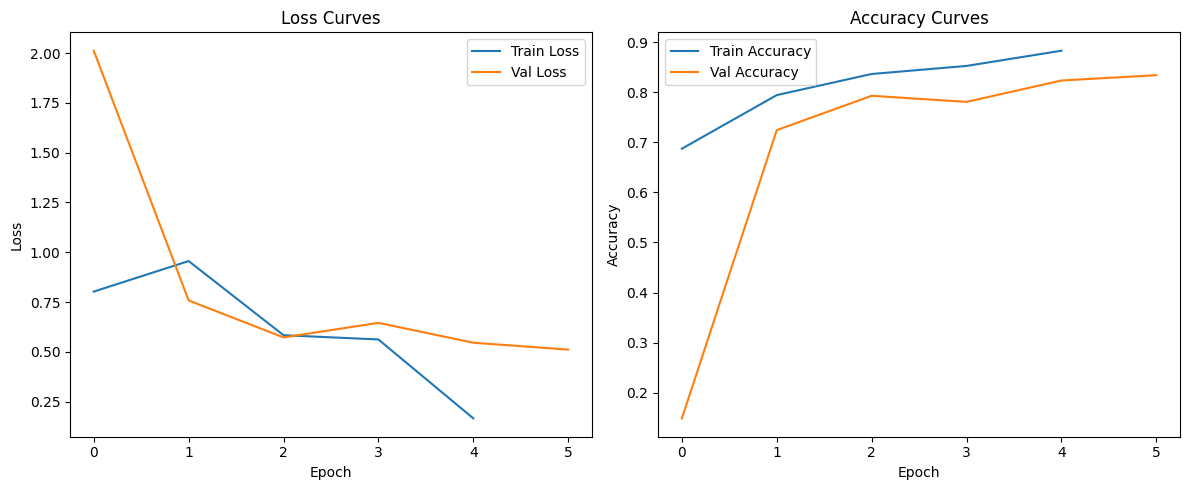

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.81992506980896
        test_loss           0.5508634448051453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


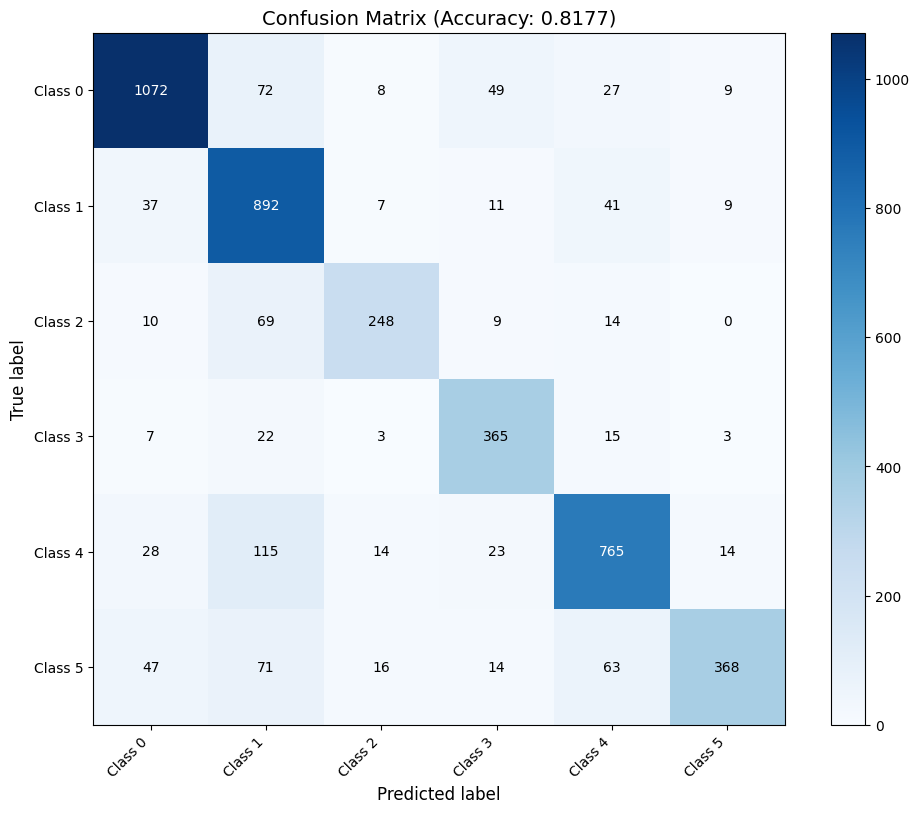

In [26]:
model_aug, results_aug, metrics_df_aug = run_experiment(
    params["model_densenet121"],
    params["num_classes_6"],
    use_augmentation=True,
)

The only difference between the above two runs is that the first one is without augmentations, and the second one is with augmentations. Though train_acc didn't improve, test_acc did improve from `0.79` to `0.82`. So using data augmentations does improve model performance on test, meaning that it performs better on unseen data, i.e., data augmentations improve generalization. Suppper nice!

2. Train baseline model w data augmentaitons w SGD Optimizer, Adam Optimizer, AdamW Optimizer, RMSprop Optimizer.

In [27]:
optimizers = ['adamw', 'rmsprop'] # baseline model uses adam, so i skip it here
optimizer_results = {}

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 7.0 M  | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.754
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: kn

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.057 >= min_delta = 0.001. New best score: 0.811
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.018 >= min_delta = 0.001. New best score: 0.829
`Trainer.fit` stopped: `max_epochs=5` reached.


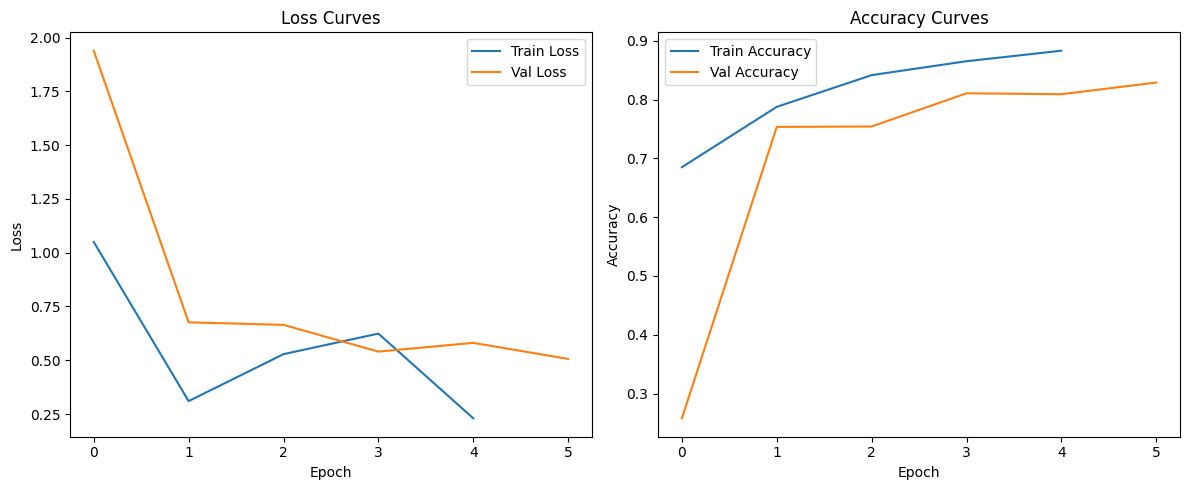

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8135331869125366
        test_loss           0.5868563652038574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


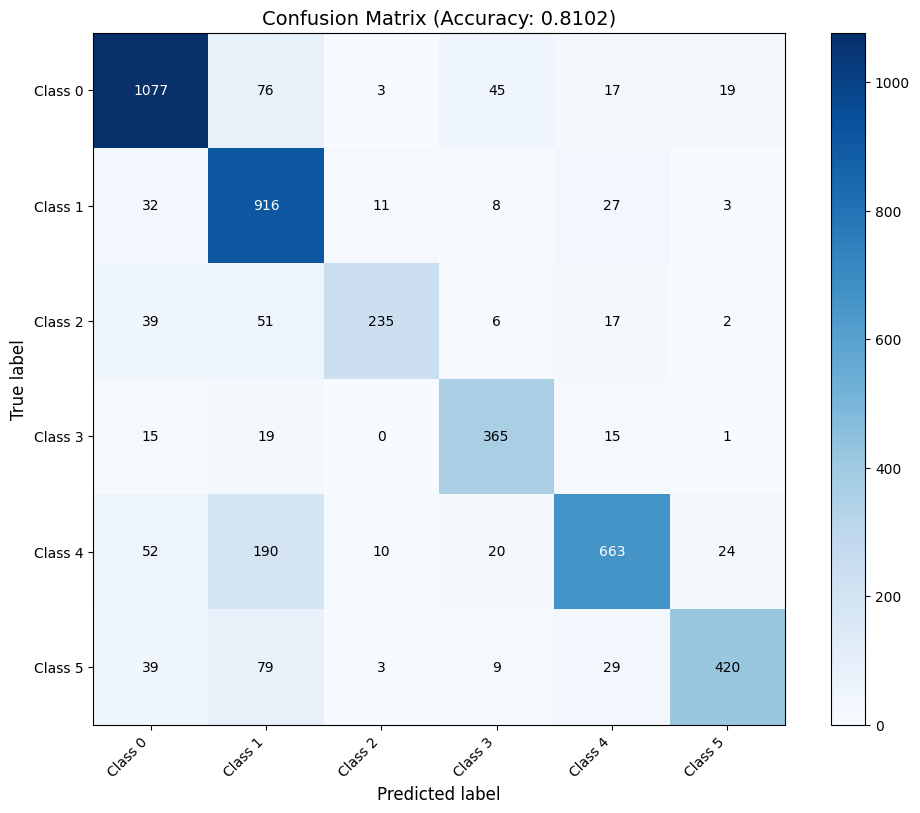

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 7.0 M  | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.344
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space no

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.077 >= min_delta = 0.001. New best score: 0.421
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
C

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.060 >= min_delta = 0.001. New best score: 0.481
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile'

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.153 >= min_delta = 0.001. New best score: 0.634
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
`Trainer.fit` stopped: `max_epochs=5` reached.


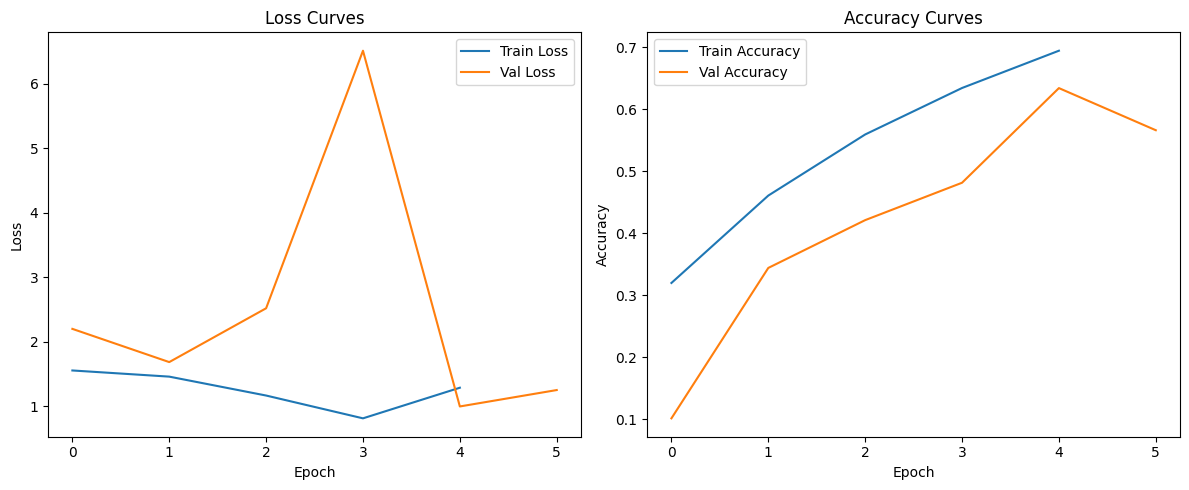

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5876129865646362
        test_loss           1.2334548234939575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


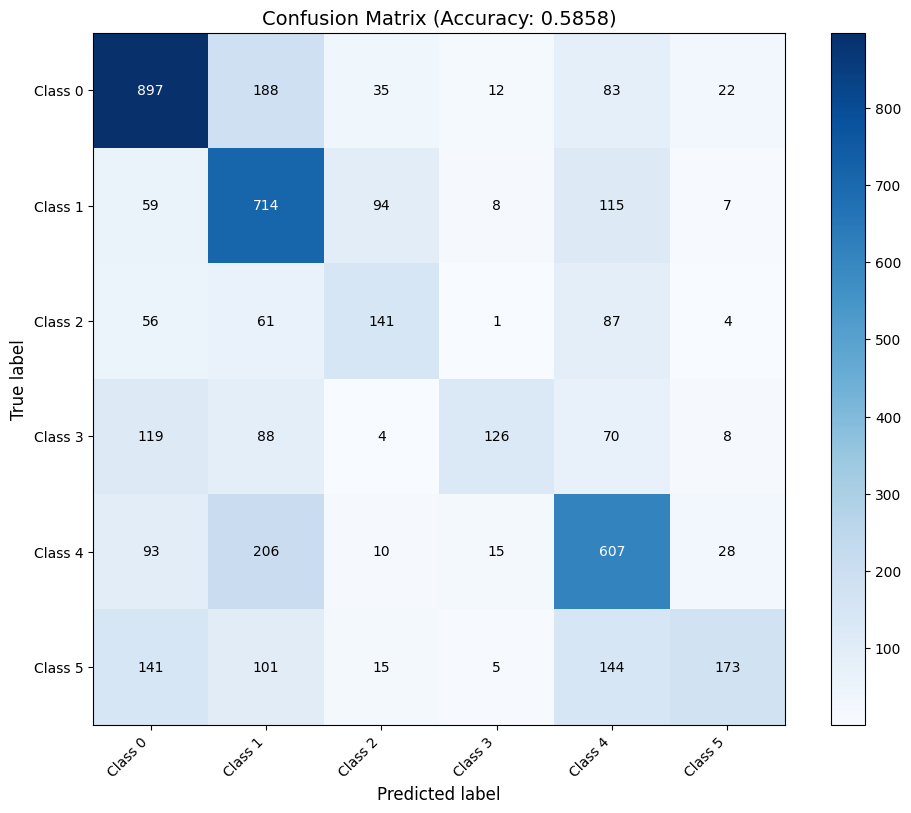

In [28]:
for opt in optimizers:
    model, results, metrics_df = run_experiment(
        params["model_densenet121"],
        params["num_classes_6"],
        optimizer=opt,
    )
    optimizer_results[opt] = results

As of above test `adam` still performs better, so i keep it.

3. Train baseline model w data augmentaiton w StepLR Scheduler, Cosine Annealing Scheduler, Cyclical Learning Rate.

In [29]:
schedulers = ['steplr', 'cosine']
scheduler_results = {}

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 7.0 M  | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.725
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.075 >= min_delta = 0.001. New best score: 0.800
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
lib

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.033 >= min_delta = 0.001. New best score: 0.833
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Cor

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
`Trainer.fit` stopped: `max_epochs=5` reached.


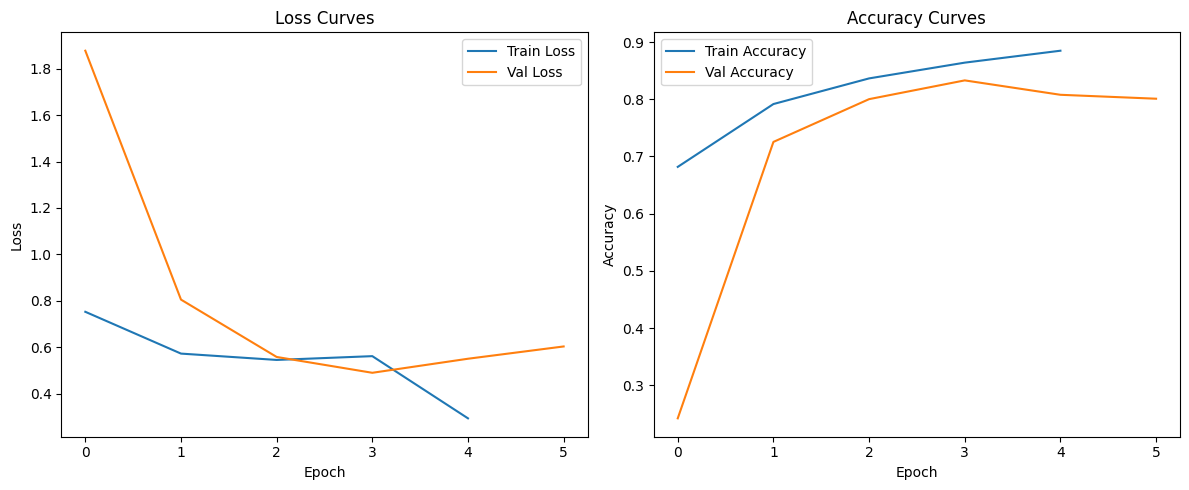

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7925942540168762
        test_loss           0.6607716083526611
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


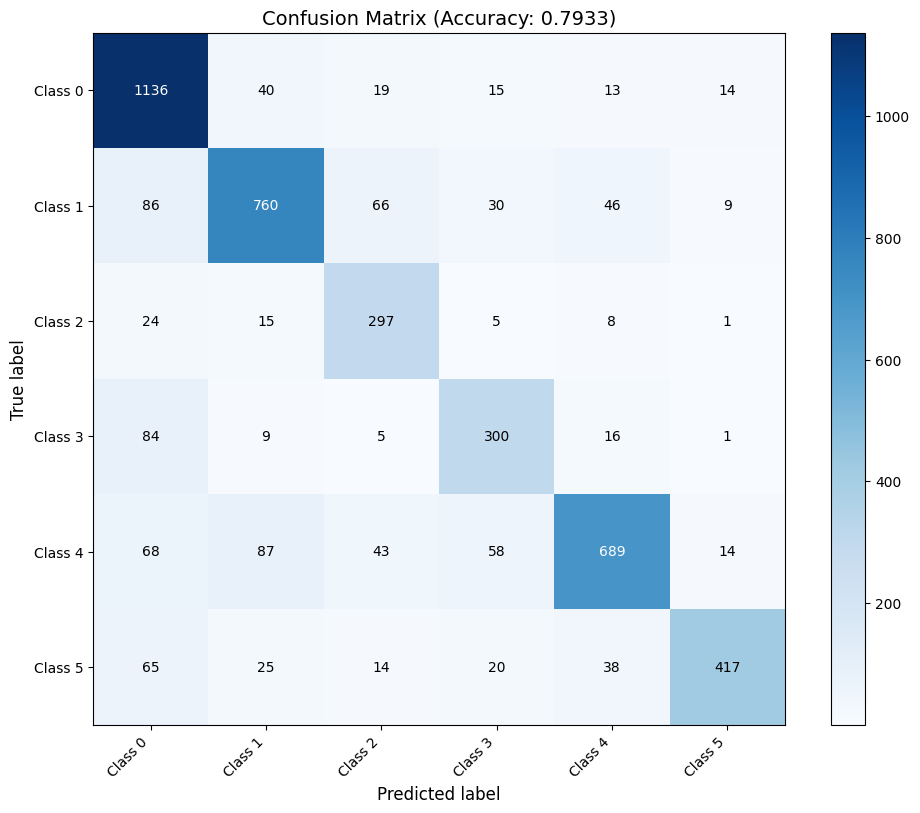

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 7.0 M  | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.753
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.049 >= min_delta = 0.001. New best score: 0.802
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before mark

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.008 >= min_delta = 0.001. New best score: 0.810
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng war

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.021 >= min_delta = 0.001. New best score: 0.831
`Trainer.fit` stopped: `max_epochs=5` reached.


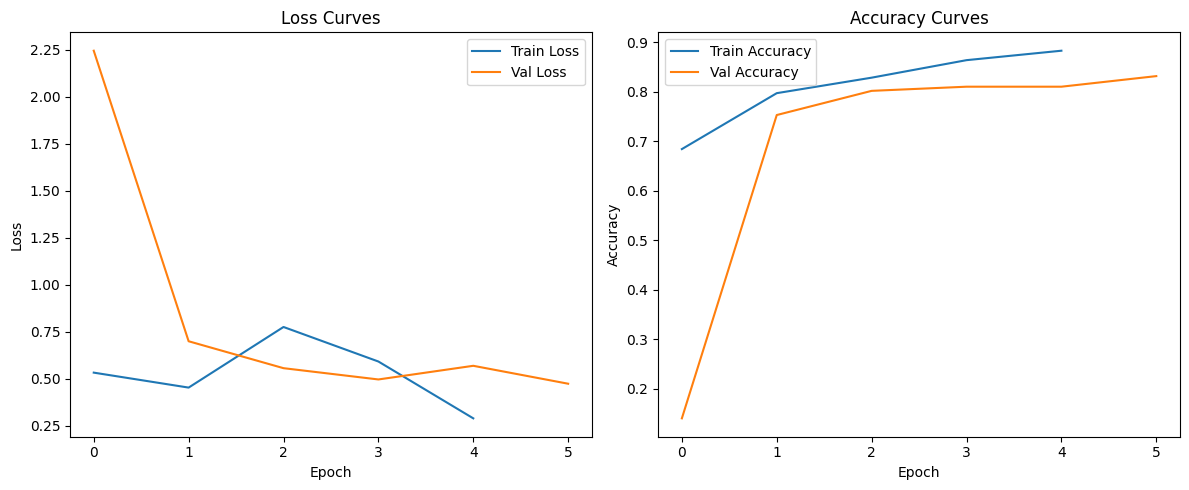

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8349129557609558
        test_loss           0.46106821298599243
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


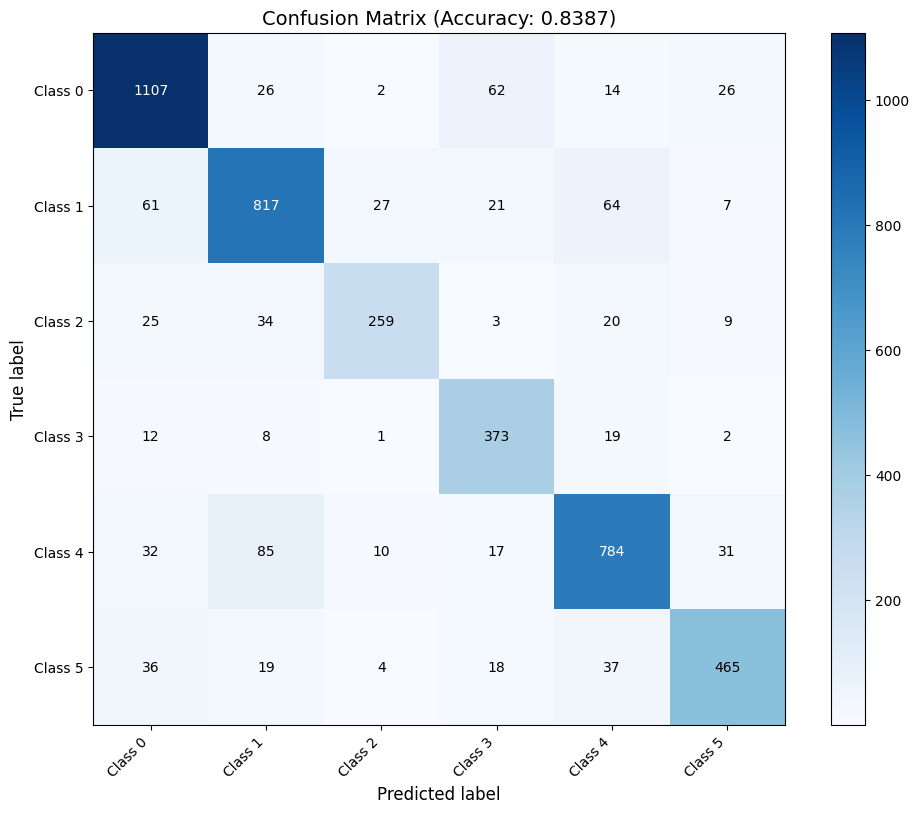

In [30]:
for sch in schedulers:
    model, results, metrics_df = run_experiment(
        params["model_densenet121"],
        params["num_classes_6"],
        optimizer=sch,
    )
    scheduler_results[sch] = results

`cosine` scheduler improves model performace, so i keep it.

4. Train different DenseNet variants: densenet121, densenet161, densenet169, and densenet201.

In [31]:
architectures = ["densenet121", "densenet161", "densenet169", "densenet201"]
architecture_results = {}

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /root/hw2/checkpoints/densenet121_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Ty

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.743
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneou

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.026 >= min_delta = 0.001. New best score: 0.769
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscal

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.031 >= min_delta = 0.001. New best score: 0.800
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscal

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.007 >= min_delta = 0.001. New best score: 0.807
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorre

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
`Trainer.fit` stopped: `max_epochs=5` reached.


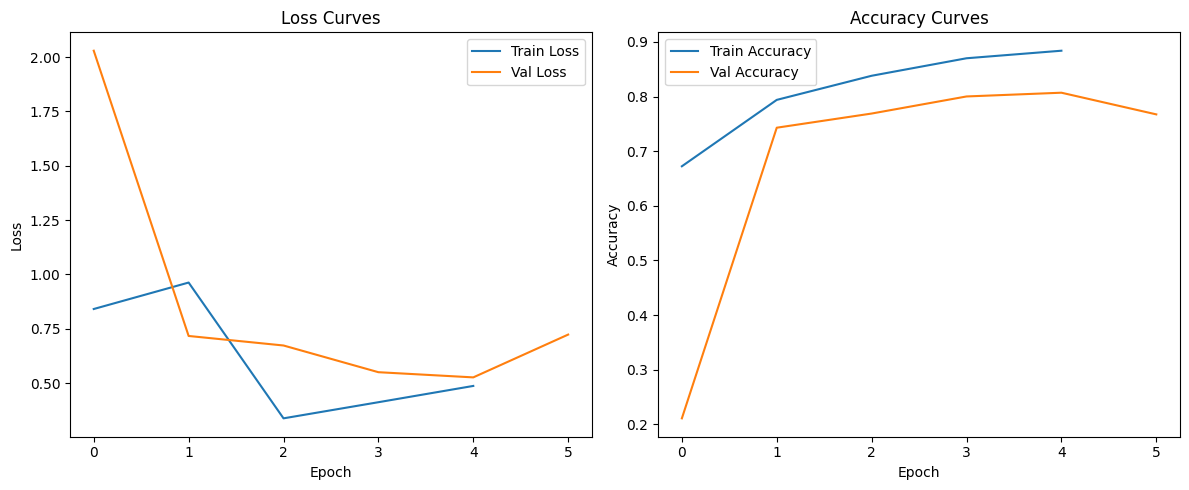

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.777385950088501
        test_loss           0.7010660767555237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


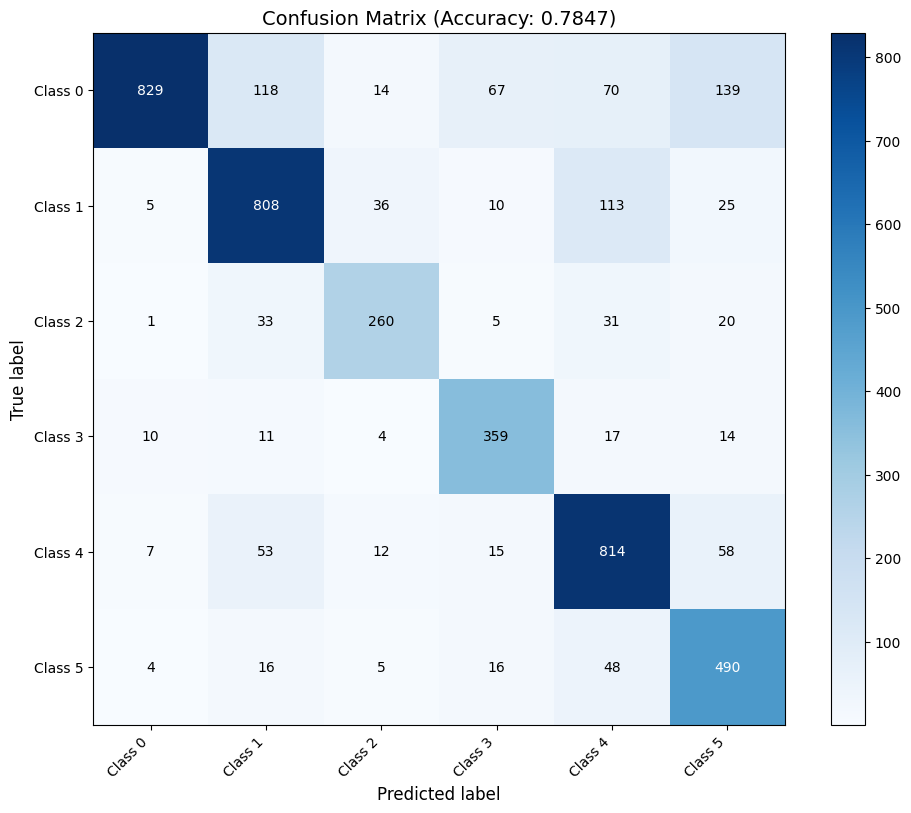

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 228MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.614
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: kn

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.150 >= min_delta = 0.001. New best score: 0.764
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.778
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
C

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.047 >= min_delta = 0.001. New best score: 0.825
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscal

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
`Trainer.fit` stopped: `max_epochs=5` reached.


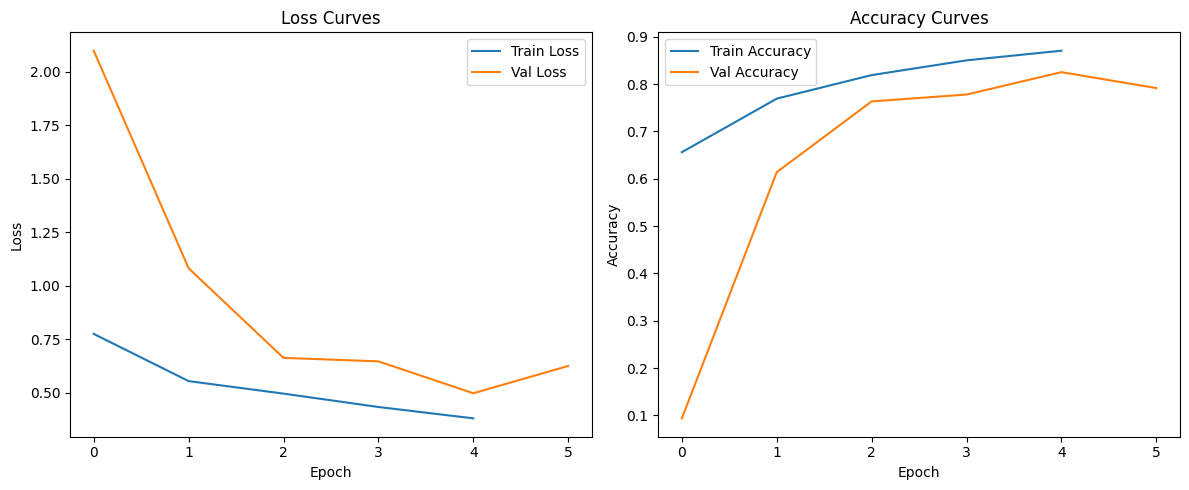

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7983248829841614
        test_loss           0.5887377262115479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


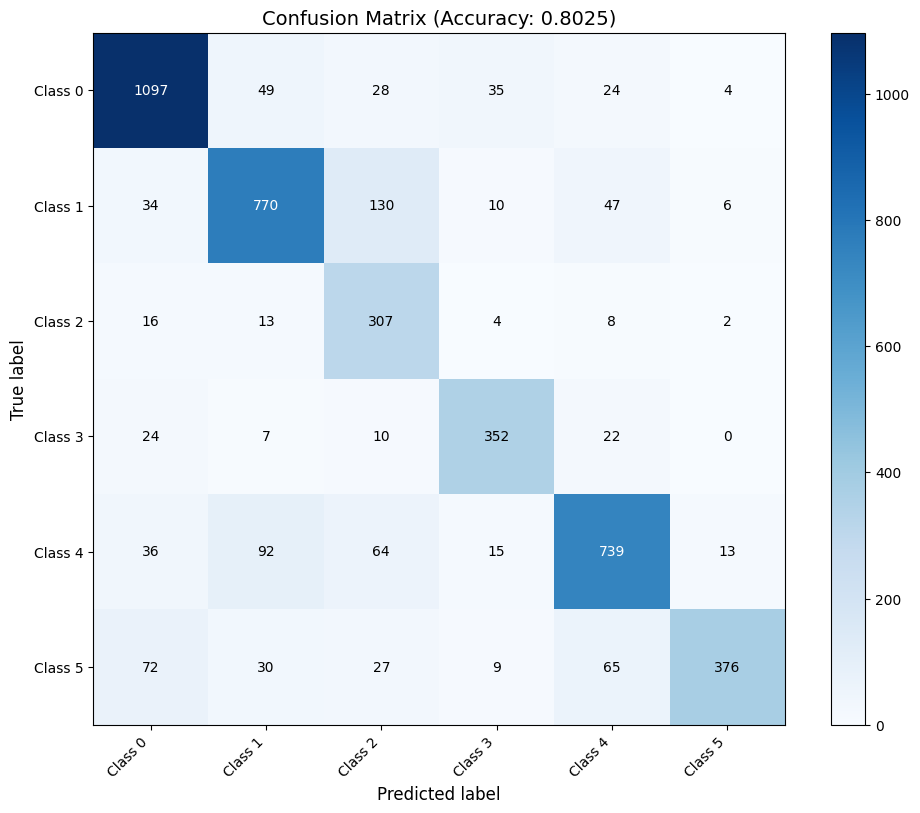

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 227MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.706
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: kn

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.056 >= min_delta = 0.001. New best score: 0.762
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.038 >= min_delta = 0.001. New best score: 0.800
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
l

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.814
`Trainer.fit` stopped: `max_epochs=5` reached.


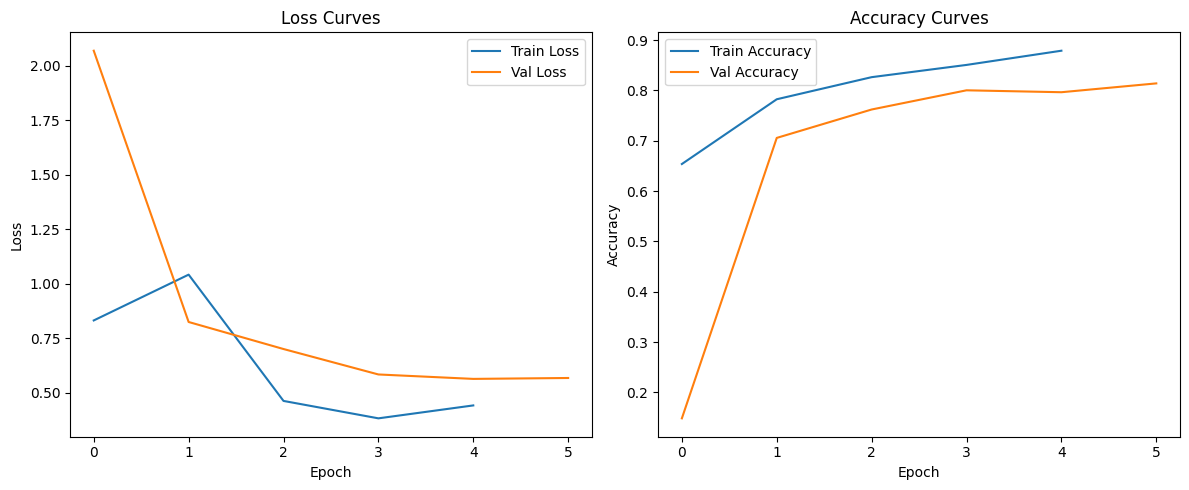

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8102270364761353
        test_loss            0.568179726600647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


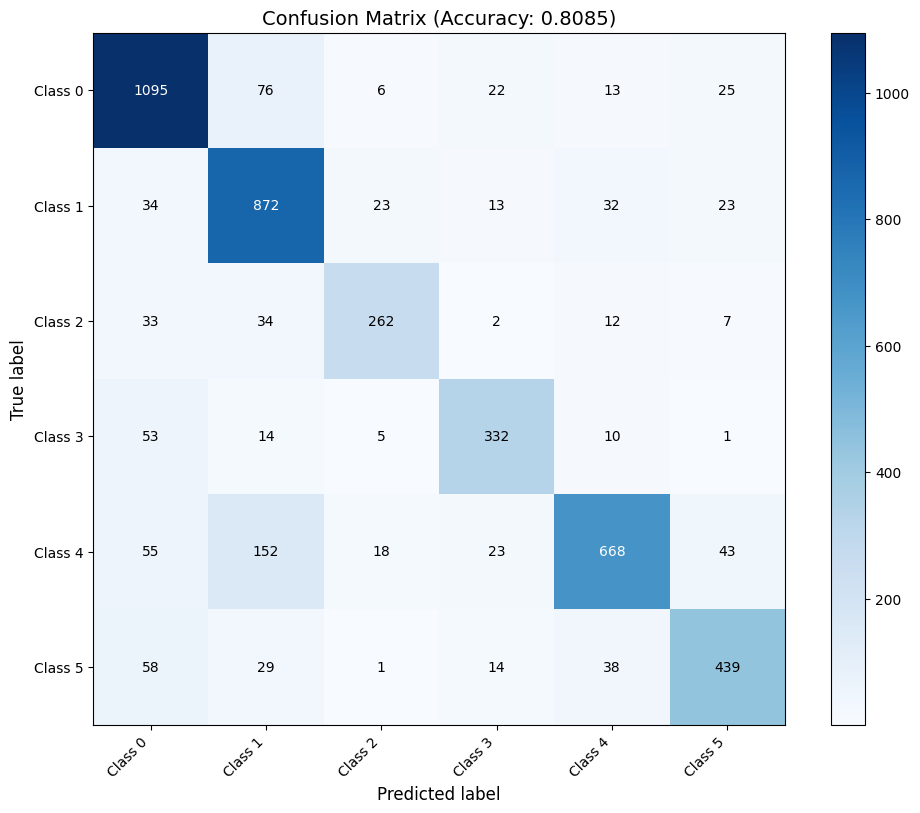

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 229MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.737
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: kn

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.041 >= min_delta = 0.001. New best score: 0.778
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.049 >= min_delta = 0.001. New best score: 0.827
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
l

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
`Trainer.fit` stopped: `max_epochs=5` reached.


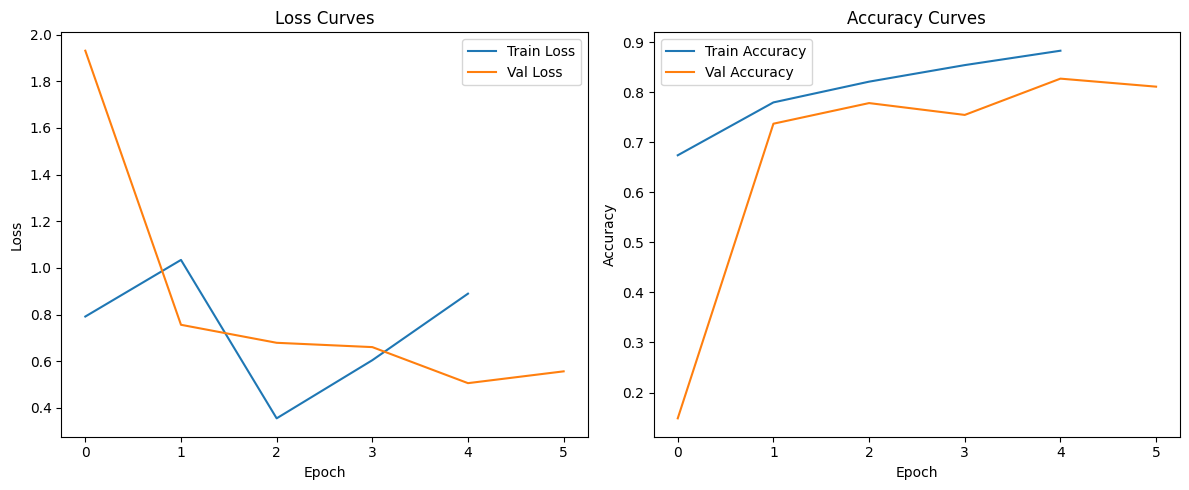

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8163985013961792
        test_loss           0.5743077993392944
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


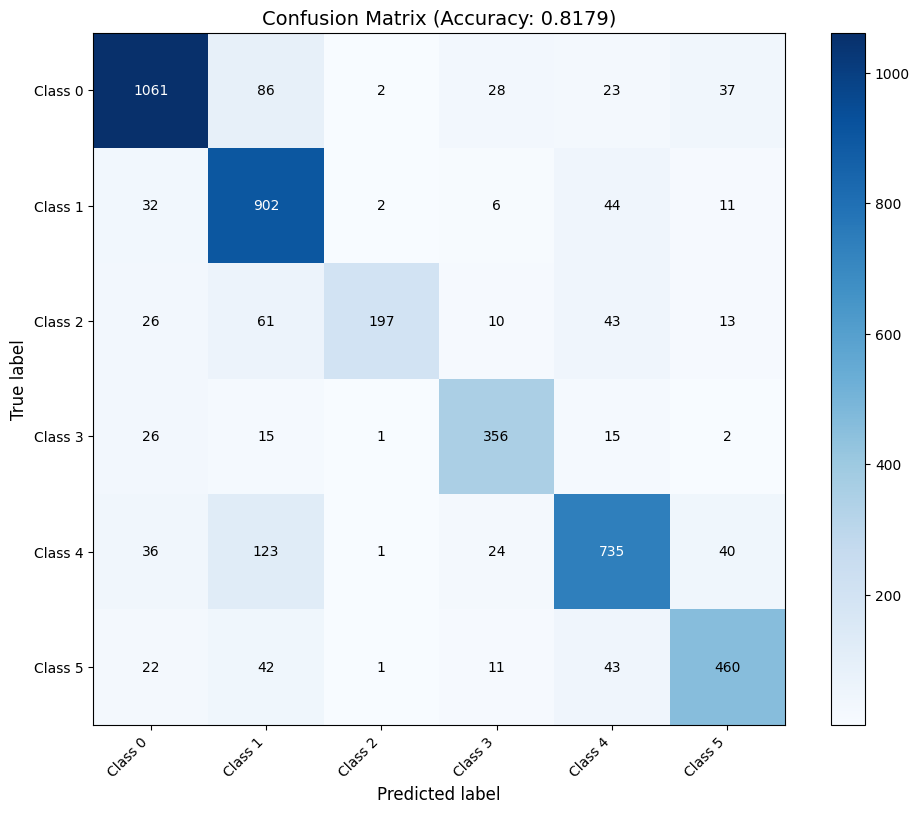

In [32]:
architecture_results = {}
for model_name in architectures:
    model, results, metrics_df = run_experiment(
        model_name,
        params["num_classes_6"],
    )
    architecture_results[model_name] = results

As expected increasing the depth of the model improves performance, but comes at the cost of increased computational complexity and potential overfitting.

5. Train with different activation functions: nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.Sigmoid(), nn.Tanh().

In [33]:
activations = [nn.ELU, nn.GELU] # nn.ReLU is in the baseline model, so i skip it here
activation_results = {}

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 7.0 M  | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.394
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.038 >= min_delta = 0.001. New best score: 0.432
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.089 >= min_delta = 0.001. New best score: 0.521
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ic

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.002 >= min_delta = 0.001. New best score: 0.523
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before mark

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.009 >= min_delta = 0.001. New best score: 0.532
`Trainer.fit` stopped: `max_epochs=5` reached.


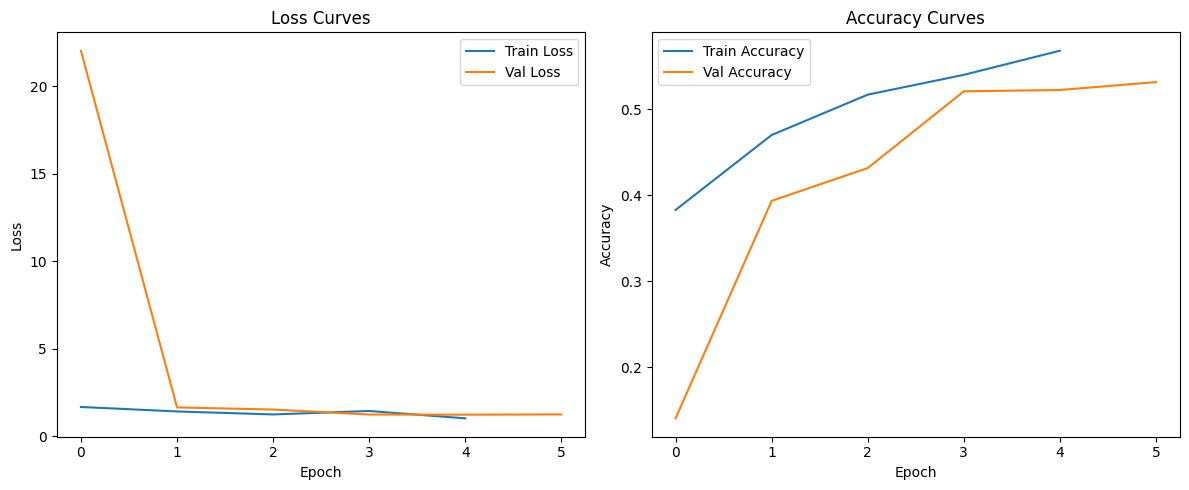

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5503636598587036
        test_loss           1.2213224172592163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


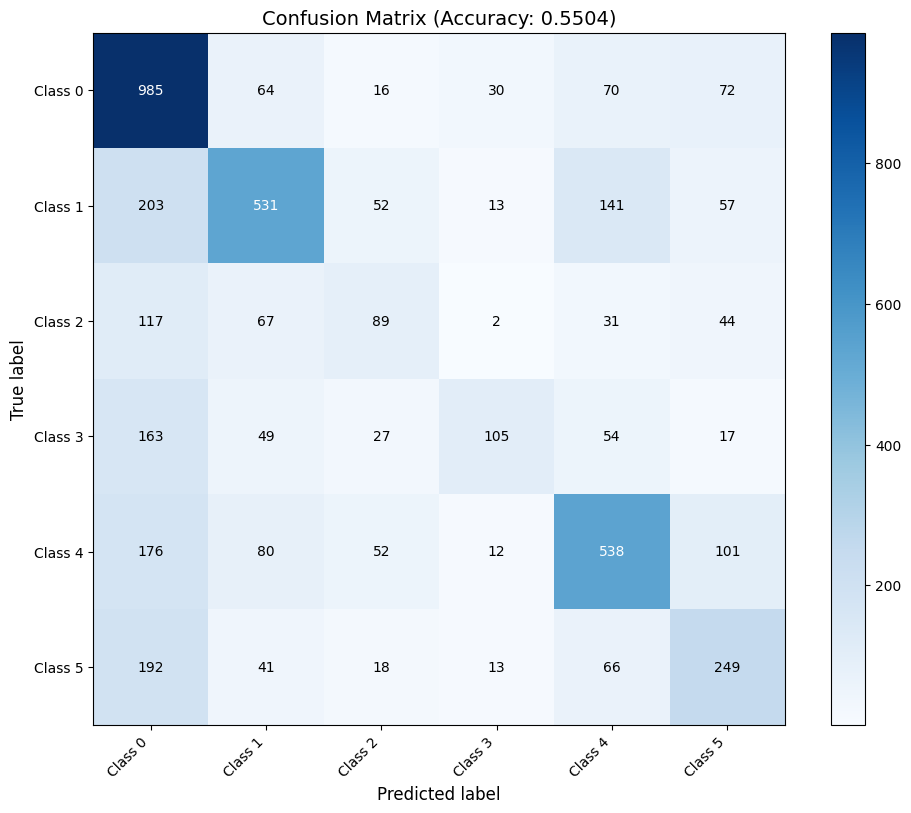

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 7.0 M  | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.548
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incor

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.039 >= min_delta = 0.001. New best score: 0.587
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
C

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.081 >= min_delta = 0.001. New best score: 0.667
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.681
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile'

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.008 >= min_delta = 0.001. New best score: 0.689
`Trainer.fit` stopped: `max_epochs=5` reached.


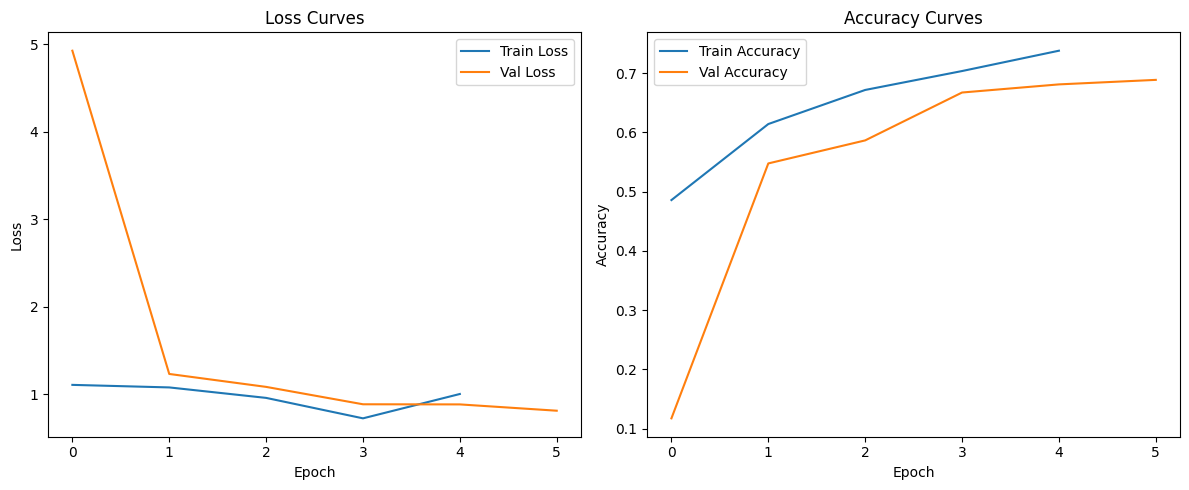

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7070751786231995
        test_loss           0.7967362403869629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


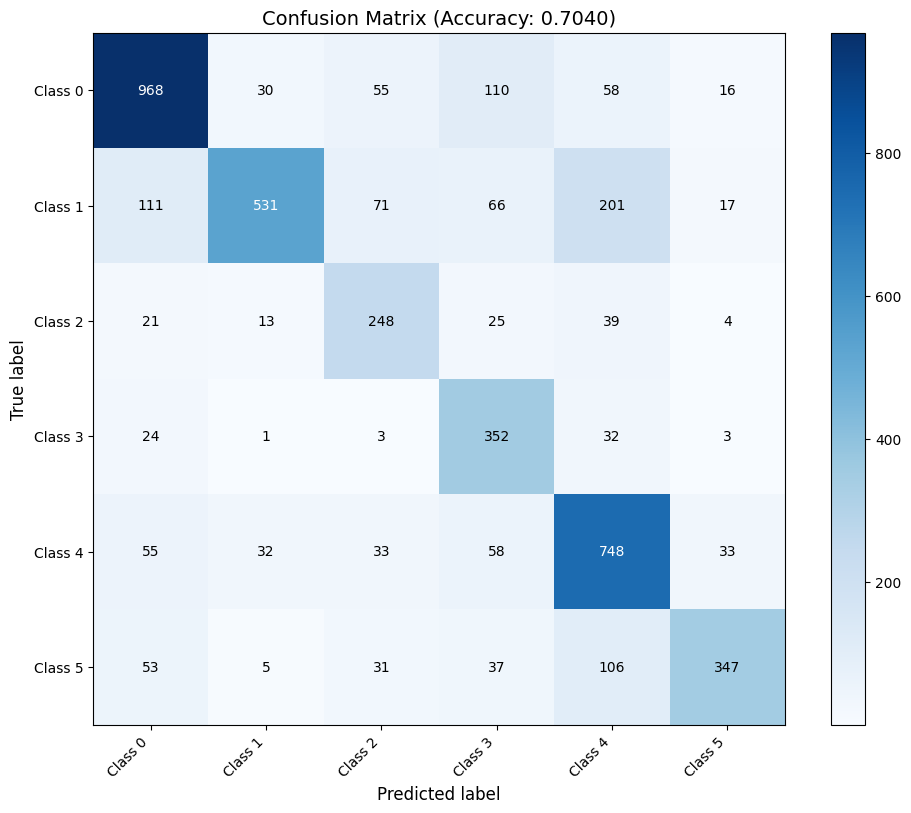

In [34]:
for act_func in activations:
    model, results, metrics_df = run_experiment(
        params["model_densenet121"],
        params["num_classes_6"],
        activation_func=act_func,
    )
    activation_results[act_func.__name__] = results

did not improve performance

From the above experiments, I choose the best model configuration and train the model one last time.

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 18.1 M | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.730
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.048 >= min_delta = 0.001. New best score: 0.778
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorre

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.038 >= min_delta = 0.001. New best score: 0.816
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorre

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.021 >= min_delta = 0.001. New best score: 0.837
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.002 >= min_delta = 0.001. New best score: 0.839
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'IC

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.031 >= min_delta = 0.001. New best score: 0.870
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.014 >= min_delta = 0.001. New best score: 0.883
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes bef

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.017 >= min_delta = 0.001. New best score: 0.900
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before mark

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space 

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.002 >= min_delta = 0.001. New best score: 0.902
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.002 >= min_delta = 0.001. New best score: 0.903
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Monitored metric val_acc did not improve in the last 3 records. Best score: 0.903. Signaling Trainer to stop.


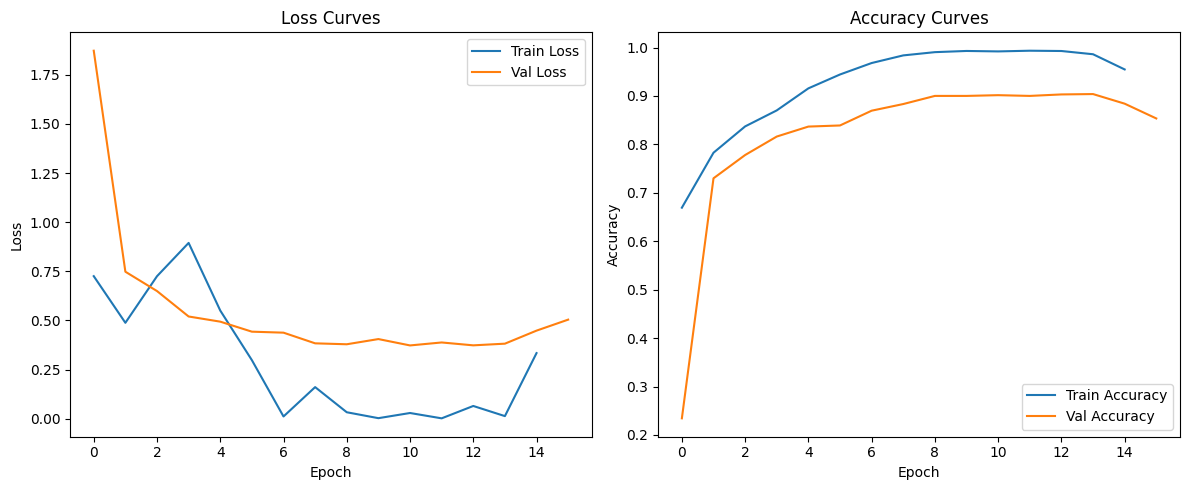

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8479171395301819
        test_loss           0.5689252614974976
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


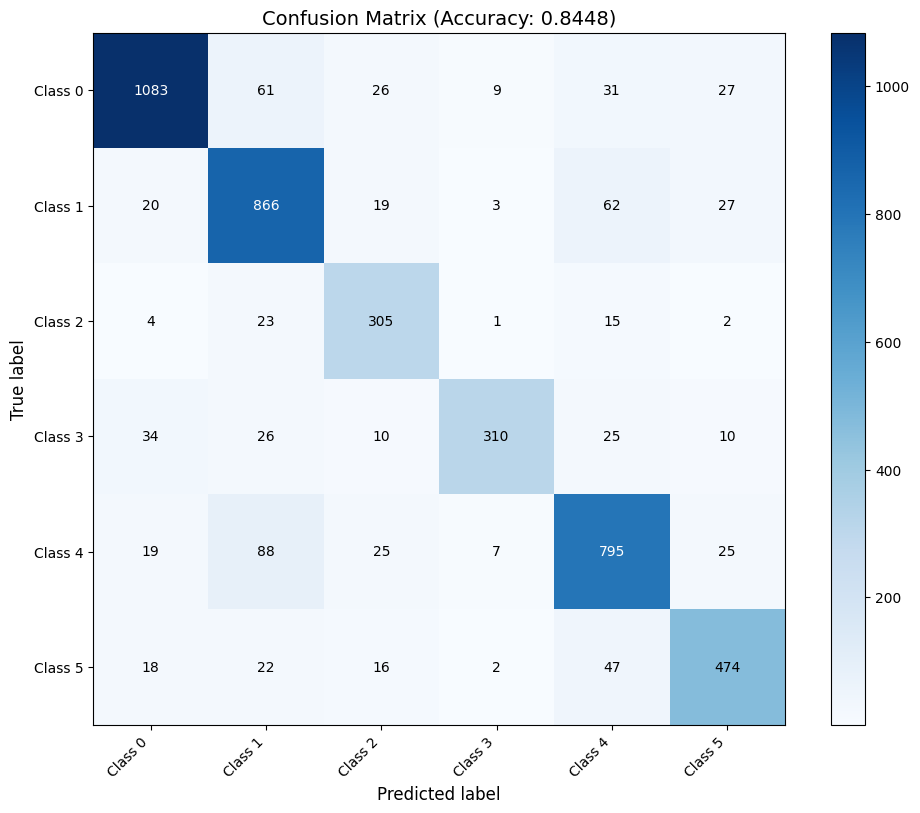

In [36]:
model_final, results_final, metrics_df_final = run_experiment(
    params["model_densenet201"],
    params["num_classes_6"],
    optimizer='adam',
    lr_scheduler_choice='cosine',
    use_augmentation=True,
    epochs=30,
    experiment_name="final_model_densenet201_cosine_30epochs",
)

In [37]:
model_final, results_final, metrics_df_final = run_experiment(
    params["model_densenet201"],
    params["num_classes_6"],
    optimizer='adam',
    lr_scheduler_choice='cosine',
    weight_decay=0.0001,
    use_augmentation=True,
    epochs=20,
    experiment_name="final_model_densenet201_cosine_30epochs_wd001",
)

/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/hw2/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | DenseNet            | 18.1 M | train
1 | criterion     | CrossEn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/root/hw2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved. New best score: 0.741
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 35 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 2932 extraneous bytes before marker 0xed
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: kn

Validation: |          | 0/? [00:00<?, ?it/s]

Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Metric val_acc improved by 0.022 >= min_delta = 0.001. New best score: 0.763


OSError: [Errno 28] No space left on device

))))) epiccc, but weight_decay should also help